In [16]:
import torch
import torchvision
from mmpose.apis.inference import init_model, init_default_scope
from matplotlib import pyplot as plt
from mmengine import Config
from mmpose.models.heads import RTMCCHead
from mmpose.models import TopdownPoseEstimator
from mmpose.apis import Pose2DInferencer, inference_topdown
from mmpose.models.backbones.cspnext import CSPNeXt
from mmpose.codecs.simcc_label import SimCCLabel


ckpt = '/root/projects/sign_language_transformer/resources/dwpose-l/dw-ll_ucoco.pth'
cfg = '/root/projects/sign_language_transformer/resources/dwpose-l/rtmpose-l_8xb64-270e_coco-ubody-wholebody-256x192.py'
device = 'cuda:1'
image = '../resources/test_image.png'

cfg = Config.fromfile(cfg)
init_default_scope('mmpose')
model: TopdownPoseEstimator = init_model(cfg, ckpt, device=device)

std = torch.tensor(cfg.model.data_preprocessor.std)
mean = torch.tensor(cfg.model.data_preprocessor.mean)

left_hand = list(range(112, 133))
righ_hand = list(range(91, 112))
body = list(range(0, 17))
face = list(range(23, 91))

left_hand_center = [121, 112]
right_hand_center = [100, 91]


Loads checkpoint by local backend from path: /root/projects/sign_language_transformer/resources/dwpose-l/dw-ll_ucoco.pth


# Prepare example data

data type: uint8


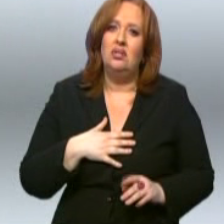

In [17]:
#prepare data
from PIL import Image
import numpy as np

def central_crop(image, crop_width, crop_height):
    # Get the dimensions of the image
    img_width, img_height = image.size

    # Calculate the coordinates for the central crop
    left = (img_width - crop_width) / 2
    top = (img_height - crop_height) / 2
    right = (img_width + crop_width) / 2
    bottom = (img_height + crop_height) / 2

    # Perform the crop
    cropped_image = image.crop((left, top, right, bottom))

    return cropped_image

image = Image.open('../resources/test_image.png')
image = central_crop(image, 224, 224)
print(f'data type: {np.array(image).dtype}')
image

In [18]:
#preprocess the data
import einops
data = torch.from_numpy(np.array(image)).float()
data = (data - std) / mean
print(f'std: {data.std()}, mean: {data.mean()}')

data = einops.rearrange(data, '(n h) w c -> n c h w', n=1).to(device)
print(f'data shape {data.shape}')

#affine and padding
data = torch.nn.functional.interpolate(data, (192, 192), mode='bilinear')
data = torch.nn.functional.pad(data, [0, 0, 0, 64])

print(f'data after affine {data.shape}')

std: 0.6731945276260376, mean: 0.4586787223815918
data shape torch.Size([1, 3, 224, 224])
data after affine torch.Size([1, 3, 256, 192])


# Inference Using directly tensor inputs

In [19]:
with torch.no_grad():
    x, y = model(data, None, 'tensor')
    keypoints = model.head.decode((x, y))
    x, y = (torch.squeeze(a, 0) for a in (x, y))
    x, y = (torch.nn.functional.softmax(a, dim=0) for a in (x, y))
    print(f'output size: {y.shape} and {x.shape}')
    model_x, model_y = (x, y)

    # inference the exact keypoint
    # keypoints = model.head.decode((y, x))
    # keypoints = model.head.decode((y, x))
    # y, x = (a/a.max(dim=-1, keepdim=True)[0] for a in (y, x))
    map = einops.einsum(y, x, 'k y, k x -> k y x')
    map = map[face]
    map = torch.max(map, dim=0)[0]
    # map = map[2]
    # map = torch.where(map < 0.01, torch.zeros_like(map), map)

    #cut-off the padding edge and remap the position
    # map = torch.nn.functional.interpolate(map.unsqueeze(0).unsqueeze(0), [256, 192])[0, 0]
    map_output = map = map[:-128, :]
    map = torch.nn.functional.interpolate(map.unsqueeze(0).unsqueeze(0), [224, 224])[0, 0]
from mmengine.structures.instance_data import InstanceData
keypoints[0].keypoints

output size: torch.Size([133, 512]) and torch.Size([133, 384])


array([[[103.5,  33. ],
        [114. ,  27. ],
        [ 96. ,  23.5],
        [127. ,  38.5],
        [ 83.5,  30.5],
        [146.5,  85.5],
        [ 58.5,  81.5],
        [171.5, 151. ],
        [ 28.5, 155.5],
        [135.5, 162.5],
        [ 63. , 126.5],
        [126.5, 215.5],
        [ 64. , 212.5],
        [120. , 255.5],
        [  0. , 255.5],
        [ 54. ,  77.5],
        [ 54. , 255.5],
        [ 98.5, 170. ],
        [101.5, 255.5],
        [ 53. , 255.5],
        [191.5, 255.5],
        [  0. , 255.5],
        [ 58.5, 125. ],
        [ 87. ,  23.5],
        [ 85.5,  29.5],
        [ 85. ,  35. ],
        [ 85. ,  41. ],
        [ 86. ,  46. ],
        [ 88. ,  51.5],
        [ 90.5,  55.5],
        [ 95. ,  58.5],
        [100. ,  60.5],
        [105.5,  60.5],
        [111. ,  59. ],
        [114.5,  56. ],
        [119.5,  52.5],
        [121.5,  48. ],
        [123.5,  42.5],
        [125. ,  37. ],
        [125.5,  31. ],
        [ 90.5,  18.5],
        [ 93.5, 

# generate heatmap by keypoints

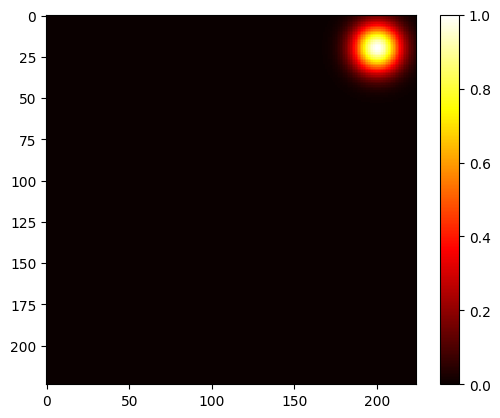

In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor
from einops import repeat

@torch.no_grad()
def gaussian_heatmap(height, width, center_x: Tensor, center_y: Tensor, sigma: Tensor, device='cuda:1'):
    # sigma [stage]
    # [n ]
    # 创建网格
    N, = center_x.shape
    S, = sigma.shape

    x_coords = torch.arange(0, width).float().to(device)
    y_coords = torch.arange(0, height).float().to(device)
    y_grid, x_grid = torch.meshgrid(y_coords, x_coords, indexing='ij')
    y_grid, x_grid = (repeat(a, 'h w -> n s h w', n = N, s=S).contiguous() for a in (y_grid, x_grid))
    center_x, center_y = (repeat(a, 'n -> n s h w', s=S, h=height, w=width).contiguous().to(device) for a in (center_x, center_y))
    sigma = repeat(sigma, 's -> n s h w', n=N, h=height, w=width).to(device).contiguous()

    # 计算高斯分布
    gaussian = torch.exp(-((x_grid - center_x)**2 + (y_grid - center_y)**2) / (2 * sigma**2))
    gaussian = gaussian / gaussian.max()
    #[n s h w]
    return gaussian

x = torch.tensor([200, 102.1])
y = torch.tensor([20, 102.1])
sigma = torch.tensor([5., 10.])

gmap = gaussian_heatmap(224, 224, x, y, sigma)

plt.imshow(gmap.cpu().numpy()[0][1], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# 示例调用



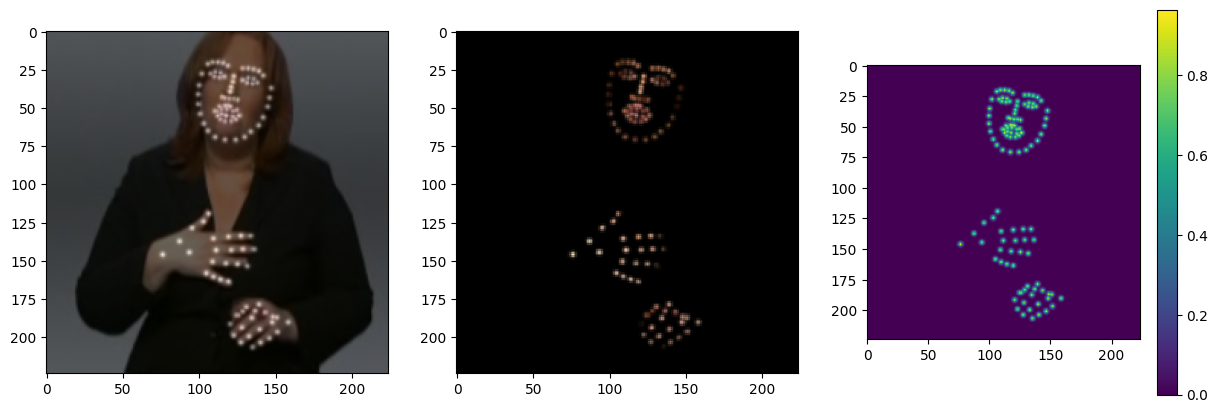

In [23]:
def decode(x, y, simcc_split_ratio):
    x_locs = x.argmax(dim=-1)
    y_locs = y.argmax(dim=-1)
    locs = torch.stack([x_locs, y_locs], dim=-1).to(x.dtype)
    locs /= simcc_split_ratio
    return locs

kps = decode(model_x, model_y, model.head.simcc_split_ratio).unsqueeze(0)


def apply_colormap(heatmap):
    """Apply a colormap to the heatmap and normalize."""
    cmap = plt.get_cmap('jet')
    heatmap_colored = cmap(heatmap)  # Apply colormap
    return heatmap_colored[..., :3]  # Discard alpha channel

def blend_images(base_img, overlay_img, alpha=0.5):
    """Blend the base image with the overlay iMage."""
    return (1 - alpha) * base_img + alpha * overlay_img


def append_centerpoints(predicted_points, centers):
    center_point = predicted_points[:, centers, :].mean(dim=1, keepdim=True)
    return torch.cat([predicted_points, center_point], dim=1)

origin = np.array(image, dtype='float32')/255.0

kps = append_centerpoints(kps, left_hand_center)
kps = append_centerpoints(kps, right_hand_center)

kps = einops.rearrange(kps, 'n k xy -> (n k) xy')
gmap = gaussian_heatmap(256, 192, kps[:, 0], kps[:, 1], torch.tensor([1., 10., 20]))
gmap = einops.rearrange(gmap, '(n k) s h w -> n k s h w', n=1)[0][:, 0]
gmap = gmap[left_hand+righ_hand+face+[133, 134]]
gmap = torch.max(gmap, dim=0)[0]
gmap = gmap[:-64]
gmap = torch.nn.functional.interpolate(gmap.unsqueeze(0).unsqueeze(0), [224, 224], mode='bilinear')[0, 0]

blend_image = blend_images(origin, gmap.unsqueeze(-1).cpu().numpy(), alpha=0.6)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(blend_image)
ax[1].imshow(gmap.unsqueeze(-1).cpu().numpy() * origin, cmap='hot', interpolation='nearest')
cb = ax[2].imshow(gmap.unsqueeze(-1).cpu().numpy())
fig.colorbar(cb)
